In [1]:
from epw import epw

In [2]:
import pandas as pd
CRC_Data = pd.read_csv('CRC_REAL.csv')

In [3]:
new_column_names = ["Hour", "Temperature", "Dew Point", "Humidity", "Wind", 
                    "Speed", "Gust", "Pressure", "Precip.Rate.", 
                    "Precip.Accum.", "UV", "Solar"]
CRC_Data.columns = new_column_names + [CRC_Data.columns[-1]]

In [4]:
for column in CRC_Data.columns:
    if column not in ["Hour", "Wind", "Date"]:
        CRC_Data[column] = CRC_Data[column].astype(str).str.replace(r'[^\d.]', '', regex=True)

In [5]:
CRC_Data = CRC_Data.drop(index=[0, 1])
CRC_Data = CRC_Data.reset_index(drop=True)


In [6]:
# Convert 'Temperature' column from Fahrenheit to Celsius
CRC_Data['Temperature'] = pd.to_numeric(CRC_Data['Temperature'], errors='coerce')
CRC_Data['Temperature'] = (CRC_Data['Temperature'] - 32) * 5.0 / 9.0

# Convert 'Dew Point' column from Fahrenheit to Celsius
CRC_Data['Dew Point'] = pd.to_numeric(CRC_Data['Dew Point'], errors='coerce')
CRC_Data['Dew Point'] = (CRC_Data['Dew Point'] - 32) * 5.0 / 9.0

# Define wind direction to degrees mapping
wind_to_degrees = {
    'North': 0,
    'NNE': 22.5,
    'NE': 45,
    'ENE': 67.5,
    'East': 90,
    'ESE': 112.5,
    'SE': 135,
    'SSE': 157.5,
    'South': 180,
    'SSW': 202.5,
    'SW': 225,
    'WSW': 247.5,
    'West': 270,
    'WNW': 292.5,
    'NW': 315,
    'NNW': 337.5
}

# Convert 'Wind' column from directions to degrees
CRC_Data['Wind'] = CRC_Data['Wind'].map(wind_to_degrees)

# Convert 'Speed' column to numeric and handle non-numeric values
CRC_Data['Speed'] = pd.to_numeric(CRC_Data['Speed'], errors='coerce')

# Fill any NaN values in 'Speed' with 0 or drop them if necessary
CRC_Data['Speed'] = CRC_Data['Speed'].fillna(0)  # Use .dropna() if you prefer to remove rows

# Convert wind speed from m/s to km/h
conversion_factor = 0.44704
CRC_Data['Speed'] = CRC_Data['Speed'] * conversion_factor

# Convert 'Pressure', 'Precip.Rate.', and 'Precip.Accum.' from inches to meters
inch_to_meter = 0.0254
CRC_Data['Precip.Rate.'] = pd.to_numeric(CRC_Data['Precip.Rate.'], errors='coerce') * inch_to_meter
CRC_Data['Precip.Accum.'] = pd.to_numeric(CRC_Data['Precip.Accum.'], errors='coerce') * inch_to_meter

In [7]:
CRC_Data

,Hour,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip.Rate.,Precip.Accum.,UV,Solar,Date
0,12:00 AM,13.777778,12.777778,93,270.0,0.0,,29.91,0.0,0.0,0.0,0,2023-01-01
1,12:06 AM,13.777778,12.777778,93,225.0,0.0,,29.92,0.0,0.0,0.0,0,2023-01-01
2,12:12 AM,13.777778,12.777778,93,247.5,0.0,,29.91,0.0,0.0,0.0,0,2023-01-01
3,12:18 AM,13.722222,12.777778,93,247.5,0.0,,29.92,0.0,0.0,0.0,0,2023-01-01
4,12:24 AM,13.722222,12.777778,93,225.0,0.0,,29.92,0.0,0.0,0.0,0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
54348,11:30 PM,8.388889,1.111111,60,225.0,0.0,,30.01,0.0,0.0,0.0,0,2023-12-31
54349,11:36 PM,8.388889,1.111111,60,225.0,0.0,,30.01,0.0,0.0,0.0,0,2023-12-31
54350,11:42 PM,8.388889,1.111111,60,225.0,0.0,,30.00,0.0,0.0,0.0,0,2023-12-31
54351,11:48 PM,8.388889,1.111111,60,225.0,0.0,,30.00,0.0,0.0,0.0,0,2023-12-31


In [8]:
testing = CRC_Data.copy()

In [9]:
testing['Datetime'] = pd.to_datetime(testing['Date'] + ' ' + testing['Hour'], format='%Y-%m-%d %I:%M %p', errors='coerce')

testing['Year'] = testing['Datetime'].dt.year
testing['Month'] = testing['Datetime'].dt.month
testing['Day'] = testing['Datetime'].dt.day

testing['Hour'] = testing['Datetime'].dt.hour

testing['Hour'] = testing['Hour'] + 1

In [10]:
#set index as the date
testing.set_index('Datetime', inplace=True)

numeric_columns = ['Temperature', 'Dew Point', 'Wind', 'Speed', 'Pressure', 'Precip.Rate.', 'Precip.Accum.']
for col in numeric_columns:
    testing[col] = pd.to_numeric(testing[col], errors='coerce')
    
#these 4 kept disappearing
for col in ['Humidity', 'Gust', 'UV', 'Solar']:
    testing[col] = pd.to_numeric(testing[col], errors='coerce')

# Resample by the specified length and calculate the average for each period
resample_len = 1
hourly_data = testing.resample(f'{resample_len}H').mean()

full_date_range = pd.date_range(start=testing.index.min(), end=testing.index.max(), freq='H')
full_date_range_df = pd.DataFrame(index=full_date_range)

#left join
hourly_data = full_date_range_df.join(hourly_data, how='left')

# Fill NaNs with the mean of each column
hourly_data.fillna(hourly_data.mean(), inplace=True)

# Reset index to turn 'Datetime' back into a column
hourly_data.reset_index(inplace=True)
hourly_data.rename(columns={'index': 'Datetime'}, inplace=True)

# Adjust the hour to start from 1 instead of 0
hourly_data['Hour'] = hourly_data['Datetime'].dt.hour + 1

# Add 'Date' column based on 'Datetime'
hourly_data['Date'] = hourly_data['Datetime'].dt.date

# Reorder columns if necessary
columns_order = ['Datetime', 'Hour', 'Temperature', 'Dew Point', 'Humidity', 'Wind', 'Speed', 'Gust', 'Pressure', 'Precip.Rate.', 'Precip.Accum.', 'UV', 'Solar', 'Date']
# Only include columns that are present in hourly_data
columns_order = [col for col in columns_order if col in hourly_data.columns]

# Reorder DataFrame
hourly_data = hourly_data[columns_order]

print(hourly_data.head())

             Datetime  Hour  Temperature  Dew Point  Humidity    Wind  Speed  \
0 2023-01-01 00:00:00     1    13.677778  12.777778      93.2  258.75    0.0   
1 2023-01-01 01:00:00     2    13.472222  12.777778      94.0  249.75    0.0   
2 2023-01-01 02:00:00     3    13.527778  12.777778      94.0  279.00    0.0   
3 2023-01-01 03:00:00     4    13.055556  12.111111      94.0  290.25    0.0   
4 2023-01-01 04:00:00     5    12.422222  11.666667      94.0  234.00    0.0   

   Gust  Pressure  Precip.Rate.  Precip.Accum.   UV  Solar        Date  
0   NaN    29.913           0.0            0.0  0.0    0.0  2023-01-01  
1   NaN    29.904           0.0            0.0  0.0    0.0  2023-01-01  
2   NaN    29.911           0.0            0.0  0.0    0.0  2023-01-01  
3   NaN    29.918           0.0            0.0  0.0    0.0  2023-01-01  
4   NaN    29.923           0.0            0.0  0.0    0.0  2023-01-01  


C:\Users\zeyuj\AppData\Local\Temp\ipykernel_9652\4066791945.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  hourly_data = testing.resample(f'{resample_len}H').mean()


In [11]:
hourly_data = hourly_data.round(1)
hourly_data

,Datetime,Hour,Temperature,Dew Point,Humidity,Wind,Speed,Gust,Pressure,Precip.Rate.,Precip.Accum.,UV,Solar,Date
0,2023-01-01 00:00:00,1,13.7,12.8,93.2,258.8,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
1,2023-01-01 01:00:00,2,13.5,12.8,94.0,249.8,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
2,2023-01-01 02:00:00,3,13.5,12.8,94.0,279.0,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
3,2023-01-01 03:00:00,4,13.1,12.1,94.0,290.2,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
4,2023-01-01 04:00:00,5,12.4,11.7,94.0,234.0,0.0,NaN,29.9,0.0,0.0,0.0,0.0,2023-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023-12-31 19:00:00,20,10.4,1.2,53.9,229.5,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31
8756,2023-12-31 20:00:00,21,9.9,1.1,55.1,235.0,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31
8757,2023-12-31 21:00:00,22,9.4,1.1,56.1,229.5,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31
8758,2023-12-31 22:00:00,23,8.9,0.9,57.9,231.8,0.0,NaN,30.0,0.0,0.0,0.0,0.0,2023-12-31


In [12]:
a = epw()
a.read('EPW_Files/USA_GA_Fulton.County.AP.722195_TMY3.epw')
test_df = a.dataframe
comparison = a.dataframe

In [13]:
# Define the custom conversion function
def convert_inhg_to_pa(series):
    return series * 3386.39

In [14]:
test_df['Year'] = 2023
test_df['Dry Bulb Temperature'] = hourly_data['Temperature']
test_df['Dew Point Temperature'] = hourly_data['Dew Point']
test_df['Relative Humidity'] = hourly_data['Humidity']#.astype(int)
test_df['Wind Direction'] = hourly_data['Wind']
test_df['Wind Speed'] = hourly_data['Speed']
# Convert the 'Pressure_inHg' column to Pascals
test_df['Atmospheric Station Pressure'] = hourly_data['Pressure'].apply(convert_inhg_to_pa)

In [15]:
id = 14

print(test_df.columns[id])
print(test_df.iloc[:,id])

Direct Normal Radiation
0       0
1       0
2       0
3       0
4       0
       ..
8755    0
8756    0
8757    0
8758    0
8759    0
Name: Direct Normal Radiation, Length: 8760, dtype: int64


In [16]:
test_df

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth,Liquid Precipitation Quantity
0,2023,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.7,12.8,93.2,101253.061,...,4500,9,999999999,300,0.062,0,88,0.17,0.0,6.0
1,2023,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.5,12.8,94.0,101253.061,...,750,9,999999999,300,0.062,0,88,0.17,999.0,99.0
2,2023,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.5,12.8,94.0,101253.061,...,15,9,999999999,300,0.062,0,88,0.17,999.0,99.0
3,2023,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.1,12.1,94.0,101253.061,...,1230,9,999999999,300,0.062,0,88,0.17,999.0,99.0
4,2023,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,12.4,11.7,94.0,101253.061,...,15,9,999999999,300,0.062,0,88,0.17,999.0,99.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,20,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,10.4,1.2,53.9,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0
8756,2023,12,31,21,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.9,1.1,55.1,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0
8757,2023,12,31,22,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.4,1.1,56.1,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0
8758,2023,12,31,23,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,8.9,0.9,57.9,101591.700,...,77777,9,999999999,110,0.062,0,88,0.16,999.0,99.0


In [17]:
a.write('Final_CRC.epw')

In [43]:
from uwg import UWG

# Define the .epw, .uwg paths to create an uwg object.
epw_path = "EPW_Files/Final_CRC.epw" # available in resources directory.

# Initialize the UWG model by passing parameters as arguments, or relying on defaults
model = UWG.from_param_args(epw_path=epw_path, bldheight=11, blddensity=0.15, 
                                vertohor=0.8, sensanth=0.835,
                                treecover=0.15, grasscover=0.35, vegstart=3, 
                                vegend=11, albveg=0.15, h_obs= 3, 
                                h_ubl1=700, windmin=7.339,
                                zone='7', nday=365)

#Campus Average:
#Building Density: 21.69%, 0.2169
#Grass Cover: 30.84%, 0.3084
#Tree Cover: 10.28%, 0.1028

#Total Vegetation: 41.11%

model.generate()
model.simulate()

# Write the simulation result to a file.
model.write_epw()


Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [39]:
variant1 = epw()
variant1.read('EPW_Files/Final_CRC_UWG.epw')
variant_df = variant1.dataframe
variant = variant_df.copy()

# Step 1: Reset index to move it to a column
variant = variant.reset_index()

# Step 2: Shift the DataFrame to the right by 1 column
variant_shifted_df = variant.shift(1, axis=1)

# Step 3: Drop the last column which is now full of NaNs
variant_shifted_df = variant_shifted_df.iloc[:, :-1].drop("index", axis = 1)
variant_shifted_df


,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Visibility,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth
0,2023,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.8,12.7,92.6,101253.061,...,11.3,4500,9,999999999,300,0.062,0,88,0.17,0.0
1,2023,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.6,12.6,93.5,101253.061,...,4.8,750,9,999999999,300,0.062,0,88,0.17,999.0
2,2023,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.6,12.6,93.6,101253.061,...,0.8,15,9,999999999,300,0.062,0,88,0.17,999.0
3,2023,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.2,12.2,93.5,101253.061,...,1.2,1230,9,999999999,300,0.062,0,88,0.17,999.0
4,2023,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,12.5,11.5,93.5,101253.061,...,0.8,15,9,999999999,300,0.062,0,88,0.17,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,20,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,10.4,1.5,53.9,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0
8756,2023,12,31,21,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.9,1.3,55.1,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0
8757,2023,12,31,22,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.4,1.1,56.1,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0
8758,2023,12,31,23,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,8.9,1.1,57.9,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0


In [19]:
r = epw()
r.read('EPW_Files/Final_CRC_UWG.epw')
result_df = r.dataframe
df_reset  = result_df.copy()

# Step 1: Reset index to move it to a column
df_reset = df_reset.reset_index()

# Step 2: Shift the DataFrame to the right by 1 column
df_shifted = df_reset.shift(1, axis=1)

# Step 3: Drop the last column which is now full of NaNs
df_shifted = df_shifted.iloc[:, :-1].drop("index", axis = 1)
df_shifted

,Year,Month,Day,Hour,Minute,Data Source and Uncertainty Flags,Dry Bulb Temperature,Dew Point Temperature,Relative Humidity,Atmospheric Station Pressure,...,Visibility,Ceiling Height,Present Weather Observation,Present Weather Codes,Precipitable Water,Aerosol Optical Depth,Snow Depth,Days Since Last Snowfall,Albedo,Liquid Precipitation Depth
0,2023,1,1,1,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.8,12.7,92.6,101253.061,...,11.3,4500,9,999999999,300,0.062,0,88,0.17,0.0
1,2023,1,1,2,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.6,12.6,93.5,101253.061,...,4.8,750,9,999999999,300,0.062,0,88,0.17,999.0
2,2023,1,1,3,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.6,12.6,93.6,101253.061,...,0.8,15,9,999999999,300,0.062,0,88,0.17,999.0
3,2023,1,1,4,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,13.2,12.2,93.5,101253.061,...,1.2,1230,9,999999999,300,0.062,0,88,0.17,999.0
4,2023,1,1,5,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,12.5,11.5,93.4,101253.061,...,0.8,15,9,999999999,300,0.062,0,88,0.17,999.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2023,12,31,20,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,10.4,1.5,53.9,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0
8756,2023,12,31,21,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.9,1.3,55.1,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0
8757,2023,12,31,22,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,9.4,1.1,56.1,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0
8758,2023,12,31,23,0,?9?9?9?9E0?9?9?9?9?9?9?9?9?9?9?9?9?9?9?9*9*9?9...,8.9,1.1,57.9,101591.700,...,16.1,77777,9,999999999,110,0.062,0,88,0.16,999.0


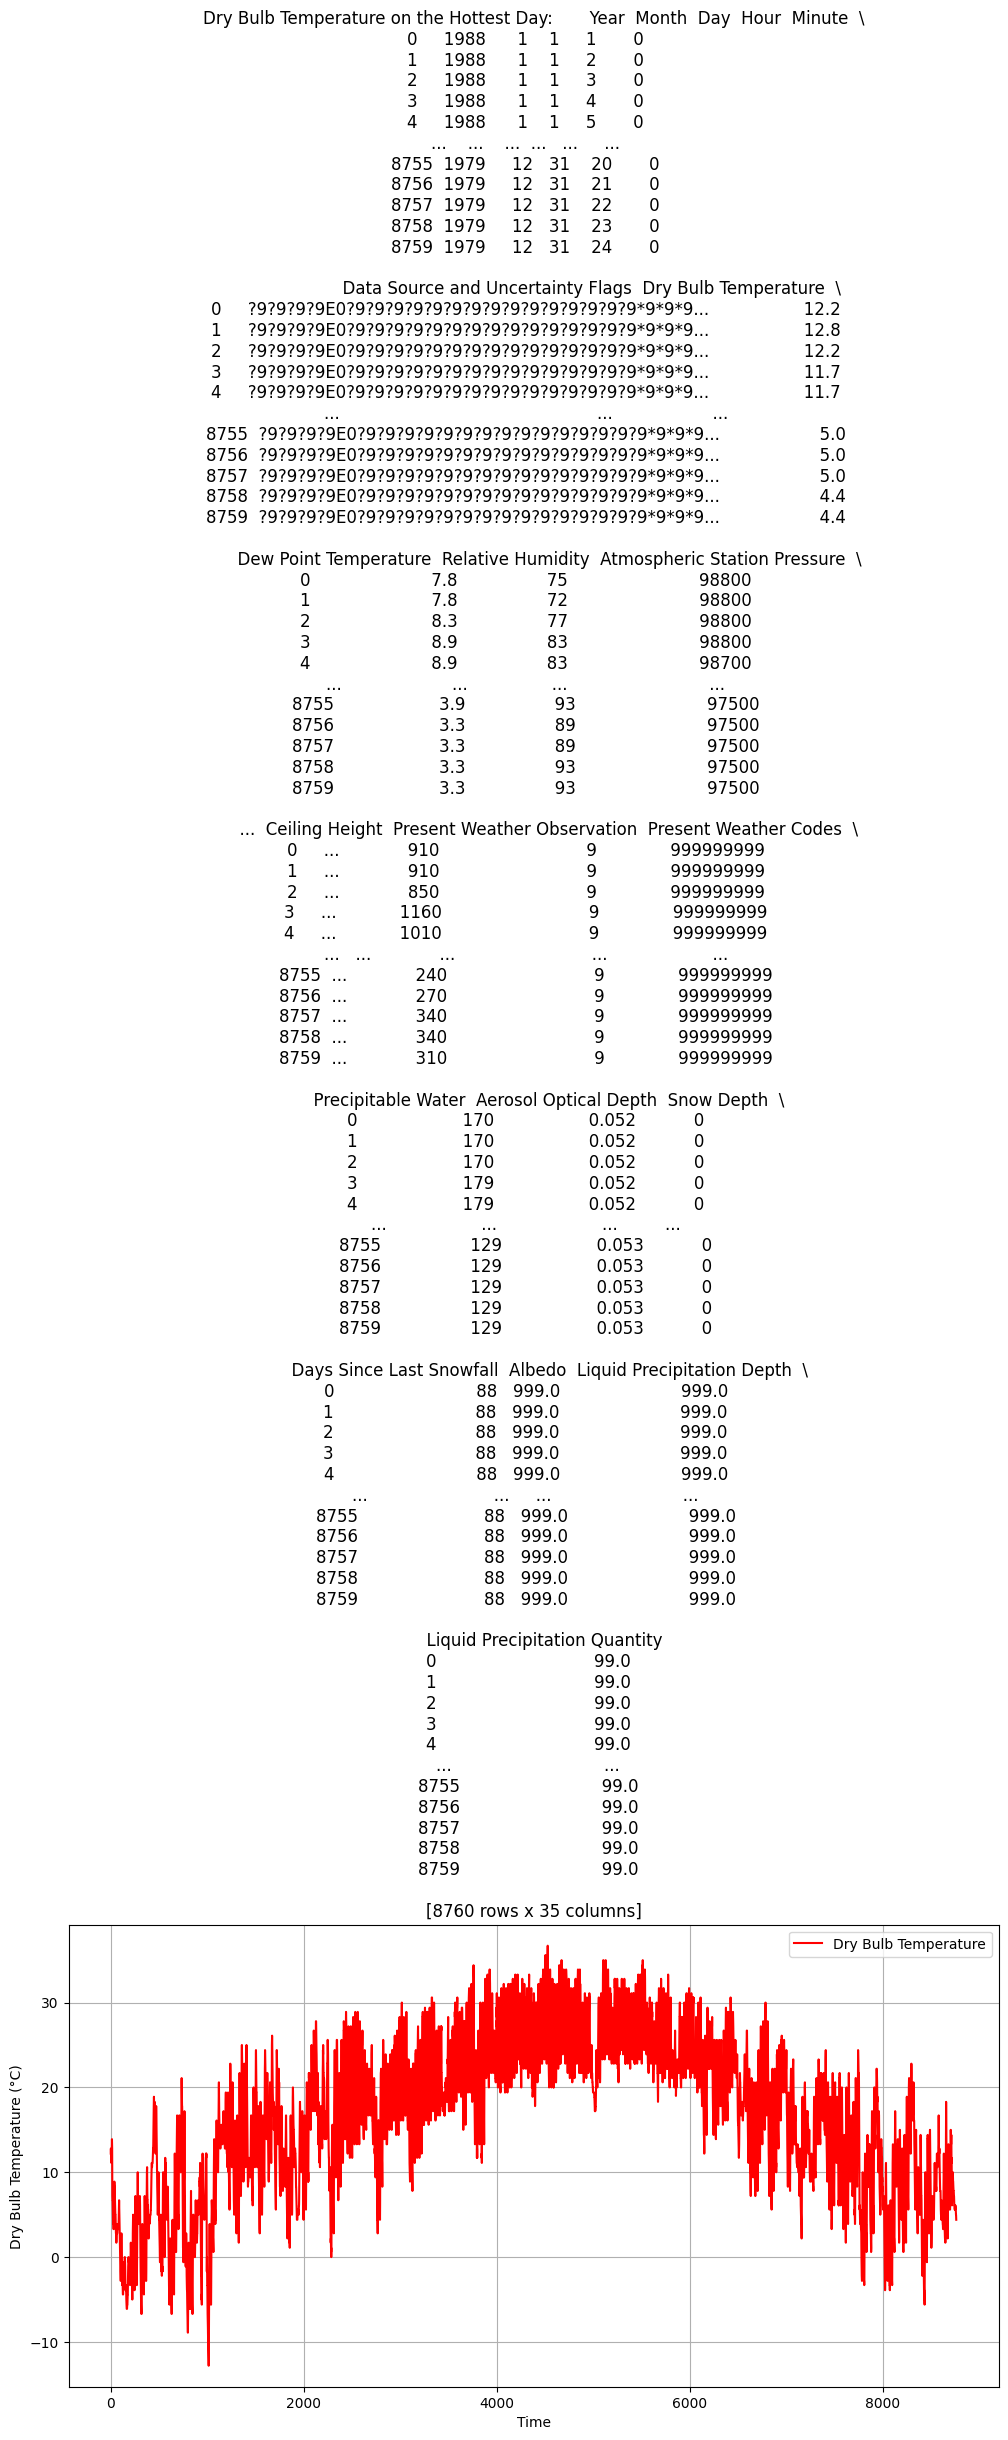

In [45]:
import matplotlib.pyplot as plt

airport = epw()
airport.read('EPW_Files/USA_GA_Atlanta-Hartsfield-Jackson.Intl.AP.722190_TMY3.epw')
airport_df = airport.dataframe


hour = 6785

df_plot = airport_df[hour:hour+24]

# Plot the temperature values for the hottest day
plt.figure(figsize=(12, 6))
plt.plot(airport_df.index, airport_df['Dry Bulb Temperature'], label='Dry Bulb Temperature', color='red')
plt.xlabel('Time')
plt.ylabel('Dry Bulb Temperature (°C)')
plt.title(f'Dry Bulb Temperature on the Hottest Day: {airport_df}')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
Final_CRC = epw()
Final_CRC.read('EPW_Files/Final_CRC.epw')
CRC_df = Final_CRC.dataframe


In [47]:
import numpy as np
np.argmax(airport_df['Dry Bulb Temperature'])

4526

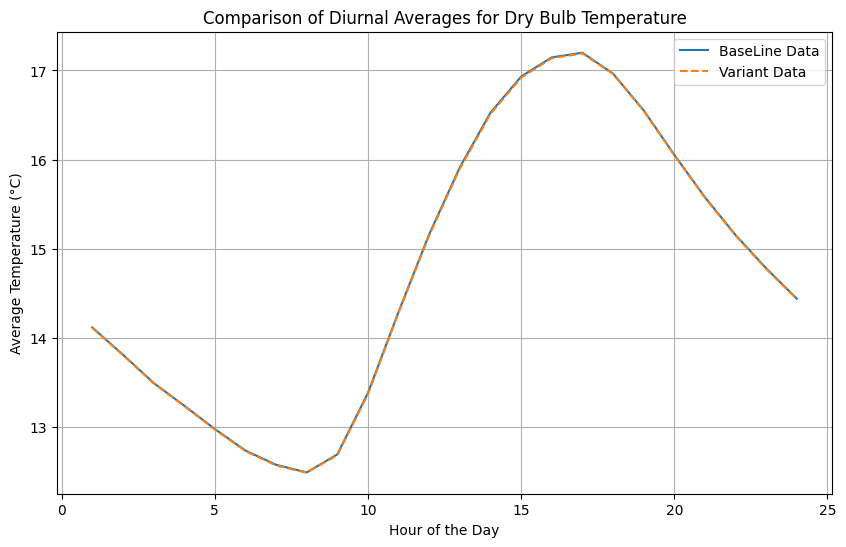

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'epw_df' is your first EPW DataFrame and 'CRC_Data' is the second one
# Both should have 'Hour' and 'Dry Bulb Temperature' columns

# Step 1: Calculate Diurnal Averages for 'Dry Bulb Temperature' for both DataFrames
diurnal_averages_epw = df_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()
diurnal_averages_crc = variant_shifted_df.groupby('Hour')['Dry Bulb Temperature'].mean()

# Step 2: Plot the Diurnal Averages for both DataFrames
plt.figure(figsize=(10, 6))
plt.plot(diurnal_averages_epw, label='BaseLine Data')
plt.plot(diurnal_averages_crc, label='Variant Data', linestyle='--')

# Step 3: Add titles and labels
plt.title('Comparison of Diurnal Averages for Dry Bulb Temperature')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Temperature (°C)')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [42]:
diurnal_averages_simulated = df_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()
diurnal_averages_original = variant_shifted_df.groupby('Hour')['Dry Bulb Temperature'].mean()

mae = (diurnal_averages_original - diurnal_averages_simulated).abs().mean()
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.007157534246575133


In [24]:
#Science Square Simulation

from uwg import UWG

# Define the .epw path to create a UWG object.
epw_path = "EPW_Files/Final_CRC.epw"

# Initialize the UWG model
model = UWG.from_param_args(epw_path=epw_path, bldheight=25, blddensity=0.0348, 
                            vertohor=0.8, sensanth=0.835,
                            treecover=0.1209, grasscover=0.3628, vegstart=3, 
                            vegend=11, albveg=0.15, h_obs=3, 
                            h_ubl1=700, windmin=7.339,
                            zone='7', nday=365)

#Science Square
#Building Density: 3.48%, 0.0348
#Grass Cover: 36.28%, 0.3628
#Tree Cover: 12.09%, 0.1209

#Total Vegetation: 48.37%


model.generate()
model.simulate()

# Write the simulation result to a file with a specified name.
model.write_epw()


Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [25]:
science_square = epw()
science_square.read('EPW_Files/Final_CRC_UWG.epw')
science_df = science_square.dataframe
sciencedf = science_df.copy()

In [26]:
# Step 1: Reset index to move it to a column
sciencedf = sciencedf.reset_index()

# Step 2: Shift the DataFrame to the right by 1 column
science_shifted = sciencedf.shift(1, axis=1)

# Step 3: Drop the last column which is now full of NaNs
science_shifted = science_shifted.iloc[:, :-1].drop("index", axis = 1)

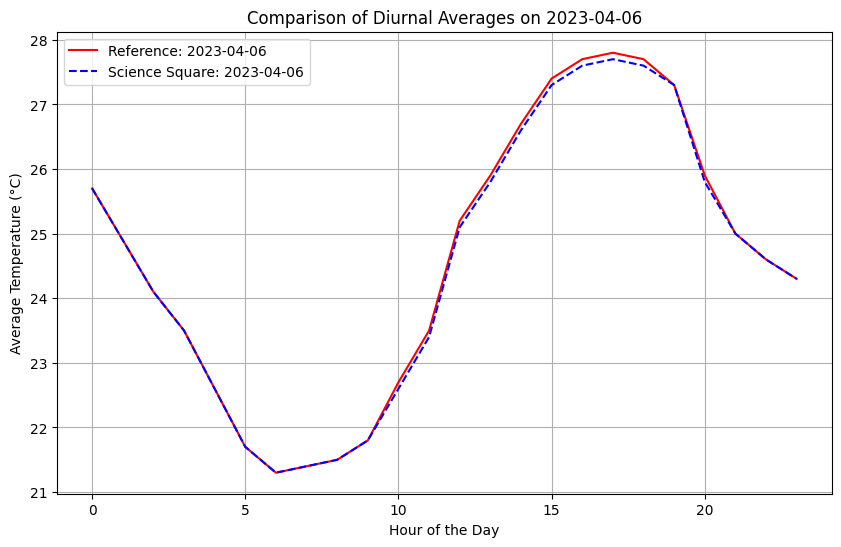

In [27]:
# Ensure 'DateTime' column exists in df_shifted
if 'DateTime' not in df_shifted.columns:
    df_shifted['DateTime'] = pd.to_datetime(CRC_df[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Ensure 'DateTime' column exists in science_shifted
if 'DateTime' not in science_shifted.columns:
    science_shifted['DateTime'] = pd.to_datetime(science_shifted[['Year', 'Month', 'Day', 'Hour', 'Minute']])

# Define the date to compare
date_to_compare = pd.Timestamp('2023-04-06')

# Filter the data for the specified date
data_df_shifted = df_shifted[df_shifted['DateTime'].dt.date == date_to_compare.date()]
data_science_shifted = science_shifted[science_shifted['DateTime'].dt.date == date_to_compare.date()]

# Step 1: Calculate Diurnal Averages for 'Dry Bulb Temperature' for the specified date
diurnal_averages_df_shifted = data_df_shifted.groupby(data_df_shifted['DateTime'].dt.hour)['Dry Bulb Temperature'].mean()
diurnal_averages_science_shifted = data_science_shifted.groupby(data_science_shifted['DateTime'].dt.hour)['Dry Bulb Temperature'].mean()

# Step 2: Plot the Diurnal Averages for both DataFrames
plt.figure(figsize=(10, 6))

plt.plot(diurnal_averages_df_shifted, label=f'Reference: {date_to_compare.date()}', color='red')
plt.plot(diurnal_averages_science_shifted, label=f'Science Square: {date_to_compare.date()}', color='blue', linestyle='--')

# Step 3: Add labels and title
plt.xlabel('Hour of the Day')
plt.ylabel('Average Temperature (°C)')
plt.title(f'Comparison of Diurnal Averages on {date_to_compare.date()}')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


In [28]:
diurnal_averages_reference = df_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()
diurnal_averages_science = science_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()

mae = (diurnal_averages_reference - diurnal_averages_science).abs().mean()
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.03224885844748856


In [29]:
from uwg import UWG

# Define the .epw path to create a UWG object.
epw_path = "EPW_Files/Final_CRC.epw"

# Initialize the UWG model
model = UWG.from_param_args(epw_path=epw_path, bldheight=30, blddensity=0.0348, 
                            vertohor=0.3, sensanth=0.835,
                            treecover=0.1209, grasscover=0.3628, vegstart=3, 
                            vegend=11, albveg=0.7, h_obs=1, 
                            h_ubl1=700, windmin=5.339,
                            zone='7', nday=365)

#Science Square
#Building Density: 3.48%, 0.0348
#Grass Cover: 36.28%, 0.3628
#Tree Cover: 12.09%, 0.1209

#Total Vegetation: 48.37%

#Vegetation
#1st increment: 53.37%: 0.4003 trees and 0.1334 grass and 0.
#2nd increment: 58.37%: 0.4378 trees and 0.1459 grass and 0.
#3rd increment: 63.37%: 0.4753 trees and 0.1584 grass and 0.
#4th increment: 68.37%: 0.5128 trees and 0.1709 grass and 0.
#5th increment: 73.37%: 0.5503 trees and 0.1834 grass and 0.

#Building
#1st increment: 8.48%:
#2nd increment: 13.48%:
#3rd increment: 18.48%:
#4th increment: 23.48%:
#5th increment: 28.48%:

model.generate()
model.simulate()

# Write the simulation result to a file with a specified name.
model.write_epw()



Simulating new temperature and humidity values for 365 days from 1/1.
Simulating Day 1
Simulating Day 2
Simulating Day 3
Simulating Day 4
Simulating Day 5
Simulating Day 6
Simulating Day 7
Simulating Day 8
Simulating Day 9
Simulating Day 10
Simulating Day 11
Simulating Day 12
Simulating Day 13
Simulating Day 14
Simulating Day 15
Simulating Day 16
Simulating Day 17
Simulating Day 18
Simulating Day 19
Simulating Day 20
Simulating Day 21
Simulating Day 22
Simulating Day 23
Simulating Day 24
Simulating Day 25
Simulating Day 26
Simulating Day 27
Simulating Day 28
Simulating Day 29
Simulating Day 30
Simulating Day 31
Simulating Day 32
Simulating Day 33
Simulating Day 34
Simulating Day 35
Simulating Day 36
Simulating Day 37
Simulating Day 38
Simulating Day 39
Simulating Day 40
Simulating Day 41
Simulating Day 42
Simulating Day 43
Simulating Day 44
Simulating Day 45
Simulating Day 46
Simulating Day 47
Simulating Day 48
Simulating Day 49
Simulating Day 50
Simulating Day 51
Simulating Day 52
Sim

In [30]:
science_increment1 = epw()
science_increment1.read('EPW_Files/Final_CRC_UWG.epw')
increment1df = science_increment1.dataframe
increment1 = increment1df.copy()

# Step 1: Reset index to move it to a column
increment1 = increment1.reset_index()

# Step 2: Shift the DataFrame to the right by 1 column
increment1_shifted = increment1.shift(1, axis=1)

# Step 3: Drop the last column which is now full of NaNs
increment1_shifted = increment1_shifted.iloc[:, :-1].drop("index", axis = 1)

In [31]:
diurnal_averages_reference = increment1_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()
diurnal_averages_science = science_shifted.groupby('Hour')['Dry Bulb Temperature'].mean()

mae = (diurnal_averages_reference - diurnal_averages_science).abs().mean()
print("Mean Absolute Error (MAE):", mae)


Mean Absolute Error (MAE): 0.038835616438356015


C:\Users\zeyuj\AppData\Local\Temp\ipykernel_9652\3863612567.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diurnal_avg = df.groupby('Hour').mean()
C:\Users\zeyuj\AppData\Local\Temp\ipykernel_9652\3863612567.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  diurnal_avg = df.groupby('Hour').mean()


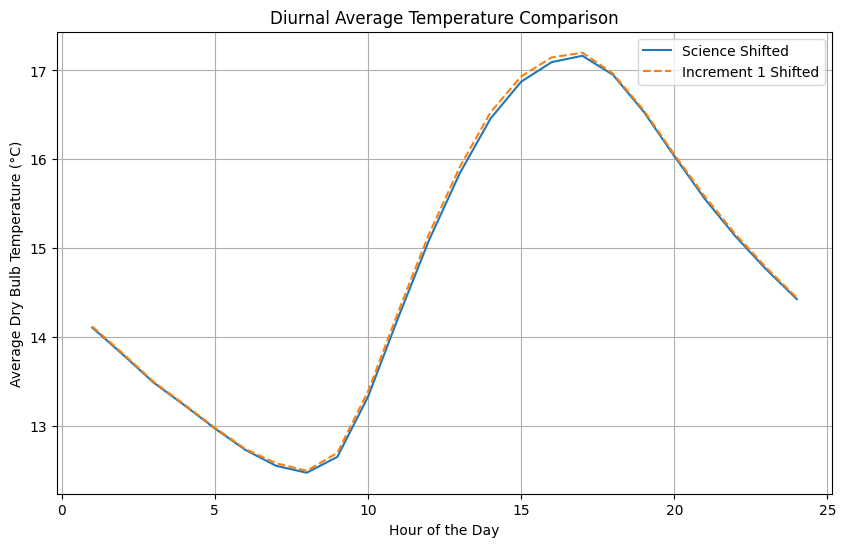

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

def calculate_diurnal_average(df):
    # Calculate diurnal average by grouping by Hour
    diurnal_avg = df.groupby('Hour').mean()
    return diurnal_avg

# Calculate diurnal averages for both DataFrames
science_diurnal_avg = calculate_diurnal_average(science_shifted)
increment1_diurnal_avg = calculate_diurnal_average(df_shifted)

# Plotting the diurnal averages
plt.figure(figsize=(10, 6))

plt.plot(science_diurnal_avg.index, science_diurnal_avg['Dry Bulb Temperature'], label='Science Shifted')
plt.plot(increment1_diurnal_avg.index, increment1_diurnal_avg['Dry Bulb Temperature'], label='Increment 1 Shifted', linestyle='--')

plt.xlabel('Hour of the Day')
plt.ylabel('Average Dry Bulb Temperature (°C)')
plt.title('Diurnal Average Temperature Comparison')
plt.legend()
plt.grid(True)     

plt.show()
